In [108]:
import numpy as np
import matplotlib.pyplot as plt
from env import Connect4env
from copy import deepcopy
import sys
from collections import defaultdict
import gym

In [109]:
env=Connect4env()
s,leg=env.reset()

In [110]:
def generate_episode_from_Q(env, Q, epsilon):
    """
    This function generates an episode using the current Q value function as a epsilon greedy policy
    """
    episode = []
    state, legal_moves = env.reset()
    while True:

        flatten_state=tuple(state.flatten()) # We use a flatten version of the state that is a matrix
        
        action = np.random.choice(legal_moves, p=get_probs(Q[flatten_state], epsilon, legal_moves)) \
                                    if flatten_state in Q else np.random.choice(legal_moves)
        
        # take a step in the environement 
        next_state, reward, legal_moves, winner  = env.step(action)

        episode.append((tuple(deepcopy(state.flatten())), action, reward[env.current_player]))
        state = next_state
        if winner!=-1 or legal_moves==[]:
            break

    return episode,winner

def get_probs(Q_s, epsilon, legal_moves):
    """ 
    obtains the action probabilities corresponding to epsilon-greedy policy 
    """
    nA=len(legal_moves)
    policy_s = [epsilon/nA]*nA

    best_action = max(legal_moves, key=lambda x: Q_s[x]) # map the best action value and select the action which is best
    index=np.where(np.array(legal_moves)==best_action)[0][0] # retrieve its index in legal move array

    policy_s[index] = 1-epsilon + epsilon/nA 
    return policy_s

In [111]:
def update_Q( episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q
        Q[state][actions[i]] = old_Q[state][actions[i]] + alpha*((discounts[:len(rewards)-i]*rewards[i:]).sum() - old_Q[state][actions[i]])
    return Q

def mc_control(env, num_episodes, alpha, gamma=0.99, eps_start=1.0, eps_decay=.9999, eps_min=0.05):
    nA = env.action_space.n

    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    rewards={1:[0],2:[0],0:[0]}
    score_store=defaultdict(lambda: [0])
    for i_episode in range(1, num_episodes+1):
        
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        epsilon = max(epsilon*eps_decay, eps_min)
 
        episode,winner = generate_episode_from_Q(env,Q,epsilon) 

        for players in [1,2,0]:
            if players==winner:
                rewards[players].append(rewards[players][-1]+1) 
            else:
                if players==0:
                    rewards[players].append(rewards[players][-1])
                else:
                    rewards[players].append(rewards[players][-1]-1)

        Q = update_Q(episode,Q,alpha,gamma) 

        if i_episode % 10 == 0:
            score_store[1].append(rewards[1][-1]-score_store[1][-1])
            score_store[2].append(rewards[2][-1]-score_store[2][-1])
            score_store[0].append(rewards[0][-1]-score_store[0][-1])
    
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q,rewards,score_store

In [112]:
num_episodes=50000
policy, Q ,dict_rewards,score_store= mc_control(env, num_episodes, 0.02)

Episode 50000/50000.

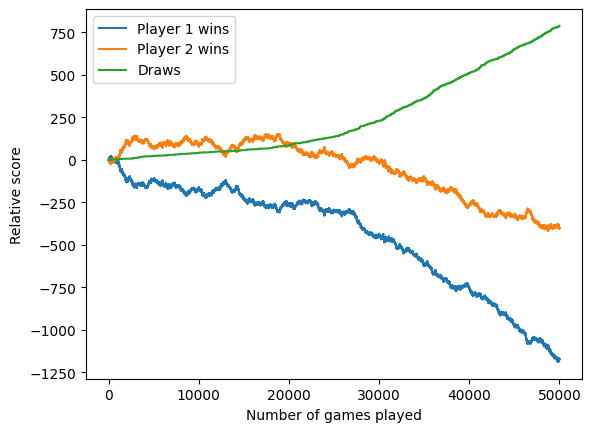

In [114]:
plt.plot(dict_rewards[1],label="Player 1 wins")
plt.plot(dict_rewards[2],label="Player 2 wins")
plt.plot(dict_rewards[0],label="Draws")
plt.xlabel("Number of games played")
plt.ylabel("Relative score")
plt.legend()